<a href="https://colab.research.google.com/github/Avipsa1/UPPP275-Notebooks/blob/main/Advanced_spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install geopandas
!pip install pysal

     |████████████████████████████████| 1.0 MB 3.8 MB/s 
     |████████████████████████████████| 16.7 MB 44.8 MB/s 
     |████████████████████████████████| 6.3 MB 39.5 MB/s 
     |████████████████████████████████| 46 kB 1.9 MB/s 
     |████████████████████████████████| 5.7 MB 6.9 MB/s 
     |████████████████████████████████| 95 kB 2.9 MB/s 
     |████████████████████████████████| 60 kB 6.8 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 2.4 MB 50.7 MB/s 
     |████████████████████████████████| 243 kB 43.6 MB/s 
     |████████████████████████████████| 83 kB 1.6 MB/s 
     |████████████████████████████████| 147 kB 51.3 MB/s 
     |████████████████████████████████| 209 kB 39.3 MB/s 
     |████████████████████████████████| 41 kB 554 kB/s 
     |████████████████████████████████| 179 kB 41.5 MB/s 
     |████████████████████████████████| 2.1 MB 39.1 MB/s 
     |████████████████████████████████| 66.7 MB 23 kB/s 
     |██████████████████████

In [4]:
#Load all necessary packages
import pysal as ps
import pandas as pd
import geopandas as gpd
import libpysal
import numpy as np
np.random.seed(0)

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Let us load the data and create the queen contiguity matrix for our analysis.

In [5]:
tracts_ca = gpd.read_file('tl_2017_06_tract.shp')
tracts_ca = tracts_ca.set_index('GEOID')
crs = '+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
tracts_ca = tracts_ca.to_crs(crs)
df_census = pd.read_csv('census_tracts_data_ca.csv', dtype={'GEOID10':str}).set_index('GEOID10')
tracts = tracts_ca.merge(df_census, left_index=True, right_index=True, how='left')
labels = tracts.index.tolist()
# calculate queen spatial weights
w_queen = libpysal.weights.Queen.from_dataframe(tracts, ids=labels, id_order=labels)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 06075980401.
  warnings.warn(message)


In [6]:
w_queen

## Standardizing spatial weights

A spatial weights matrix with raw values (e.g., binary 1s and 0s for neighbor/not) is not always the best for analysis. Some sort of standardization is useful. Typically, we want to apply a row-based transformation so every row of the matrix sums up to 1. We'll see some examples of why this matters in practice shortly.

In [7]:
# inspect the neighbors and weights of our tract
label = labels[200]
w_queen[label]

{'06065040901': 1.0,
 '06065040902': 1.0,
 '06065040903': 1.0,
 '06065041102': 1.0,
 '06065041301': 1.0,
 '06065041302': 1.0}

In [8]:
# check the current transformation of the weights matrix (O = original)
w_queen.get_transform()

'O'

In [9]:
# transform the queen weights
w_queen.set_transform('R')
w_queen[label]

('WARNING: ', '06075980401', ' is an island (no neighbors)')


{'06065040901': 0.16666666666666666,
 '06065040902': 0.16666666666666666,
 '06065040903': 0.16666666666666666,
 '06065041102': 0.16666666666666666,
 '06065041301': 0.16666666666666666,
 '06065041302': 0.16666666666666666}

In [10]:
# calculate linear decay continuous weights
x = tracts.centroid.x
y = tracts.centroid.y
coords = np.array([x, y]).T
threshold = libpysal.weights.min_threshold_distance(coords)

w_dist = libpysal.weights.distance.DistanceBand.from_dataframe(tracts,
                                                             threshold=threshold,
                                                             binary=False,
                                                             alpha=-1)


/usr/local/lib/python3.7/dist-packages/scipy/sparse/data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [11]:
# transform the linear-decay distance-based weights
w_dist.set_transform('R')
#w_dist[label]

PySAL supports the following transformations:

*   O: original, returning the object to the initial state

*  B: binary, with every neighbor having assigned a weight of 1

* R: row-based, with all the neighbors of a given observation adding up to 1

* V: variance stabilizing, with the sum of all the weights being constrained to the number of observations


It can take a long time to calculate a weights matrix for a large data set. Once you've created yours, you might want to save it to disk to re-use in subsequent analyses.

In [12]:
# save your matrix to disk
f = libpysal.io.open('tracts_queen.gal', 'w')
f.write(w_queen)
f.close()

# read a matrix from disk (notice its transformation)
w_queen = libpysal.io.open('tracts_queen.gal', 'r').read()
w_queen[label]

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 06075980401.
  warnings.warn(message)


{'06065040901': 1.0,
 '06065040902': 1.0,
 '06065040903': 1.0,
 '06065041102': 1.0,
 '06065041301': 1.0,
 '06065041302': 1.0}

## Spatial interpolation

Interpolation is a statistical method which lets you estimate unobserved values at nearby locations based on observed values from a specific location. With spatial data, you can perform spatial interpolation by filling in missing data points based on distance based relationships. This can be done using Tobler's first law of Geography: "Everything is related to everything else. But near things are more related than distant things."

The different types of interpolation teachniques are:

* **Nearest neighbor** interpolation is perhaps the simplest method: just assign the value of the nearest neighbor
* **Local averaging** assigns missing values by taking the average of adjacent neighbors or neighbors within some radius
* **Inverse distance weighting** assigns missing values using a distance weighted average: that is, the mean weighs nearby values more than it weighs distant values (and your distance decay choice is important!)
* **Kriging** is a sophisticated method that incorporates information about spatial trends and autocorrelation with a variogram


In [13]:
# how many tracts are missing values for this variable?
col = 'med_household_income'
nulls = tracts[pd.isnull(tracts[col])].index
len(nulls)

91

In [14]:
# for example, this tract is missing a value
tract = nulls[0]
tract

'06031001602'

In [15]:
# local averaging: equal-weighted queen-adjacent tracts
neighbors = w_queen[tract]
tracts.loc[neighbors, col].mean()

37238.5

In [16]:
# or, calculate inverse distance weighted mean
neighbors = w_dist[tract]
inv_dist_wt = pd.Series(neighbors)
(tracts.loc[neighbors, col] * inv_dist_wt).sum()

42556.37667629619

In [17]:
# or, interpolate all the missing values across this variable
estimates = {}
for tract in nulls:
    neighbors = w_dist[tract]
    inv_dist_wt = pd.Series(w_dist[tract])
    estimates[tract] = (tracts.loc[neighbors, col] * inv_dist_wt).sum()
pd.Series(estimates).head()

06031001602    42556.376676
06037599100    79546.976108
06031981800    47557.598998
06095980000    79412.362789
06059990100    74429.660527
dtype: float64

In [ ]:
# now it's your turn
# spatially interpolate missing values for median home value

## Spatial lag

Spatial lag tells us how values locate near other similar values. While spatial interpolation filled in unobserved (missing) values using nearby values, spatial lag lets us compare observed values to their nearby values.

Here we calculate the spatial lag of a variable. If the spatial weights matrix is row-standardized, then the spatial lag is the average value of an observation's neighbors, however "neighbor" is defined in the matrix.

In [18]:
# pick a variable to investigate and drop null rows
col = 'med_household_income'
tracts_not_null = tracts[[col, 'geometry']].dropna()
y = tracts_not_null[col]

In [19]:
# recompute spatial weights for just these observations then row-standardize
w_queen = libpysal.weights.Queen.from_dataframe(tracts_not_null)
w_queen.set_transform('R')

('WARNING: ', 6541, ' is an island (no neighbors)')


/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 6541.
  warnings.warn(message)


In [20]:
# compute spatial lag
y_lag = libpysal.weights.lag_spatial(w_queen, y)

In [21]:
# is a tract's med income similar to those of its neighbors?
col_lag = f'{col}_lag'
data_lag = pd.DataFrame(data={col:y, col_lag:y_lag}).astype(int)
data_lag

,med_household_income,med_household_income_lag
GEOID,,
06001442700,116528,106096
06001442800,102788,116689
06037204920,40871,42417
06037205110,43063,35183
06037205120,28558,42880
...,...,...
06059001303,77227,81782
06059001304,61736,68814
06059001401,61274,78696


## Spatial autocorrelation

Statistical models typically assume that the observations are independent of each other. This assumption is violated when a variable's value at one location is correlated with its value at nearby locations. This phenomena is called spatial autocorrelation.

Such spatial autocorrelation is common in the real world due to proximity-based spillover effects. For example, a home's value may be a function of its own characteristics and accessibility, but it is also a function of nearby homes' values. In other words, homes near one another tend to have similar home values.

* Positive spatial autocorrelation means nearby values tend to be more similar to each other (e.g. income, home values, temperature, rainfall)
* Negative spatial autocorrelation means nearby values tend to be more dissimilar (e.g. fire stations, libraries).

In [22]:
# does household income exhibit spatial autocorrelation?
# let's find out
data_lag.sample(5)

,med_household_income,med_household_income_lag
GEOID,,
06043000302,64702,56277
06081613600,118152,117462
06013351101,53389,139132
06037302503,34939,41038
06069000802,82794,67923


## Moran's I

Moran's I measures global spatial autocorrelation: do things tend to be near other (dis)similar things. Values > 0 indicate positive spatial autocorrelation, and values < 0 indicate negative spatial autocorrelation.

In [23]:
# calculate the statistic
import esda
from esda.moran import Moran
mi = Moran(data_lag[col], w_queen) 

In [24]:
# show the I value
mi.I

0.6855274181193025

In [25]:
# statistical inference: show the p value
mi.p_sim

0.001

If we generated a large number of maps with the same values but randomly allocated over space, and calculated Moran's I for each of these maps, only 1/1000 of them would display a larger absolute value than the one we computed from the real-world data set. Thus there is a 1/1000 chance of getting the observed value of Moran's I if the spatial distribution of our variable is random. We can conclude that the variable's distribution is statistically significantly postively spatially autocorrelated.

In [ ]:
# now it's your turn
# calculate the moran's I of median home values
# is it statistically significant? what does it tell you?

A Moran plot scatter plots the spatially-lagged values (y-axis) vs the original variable's values (x-axis).

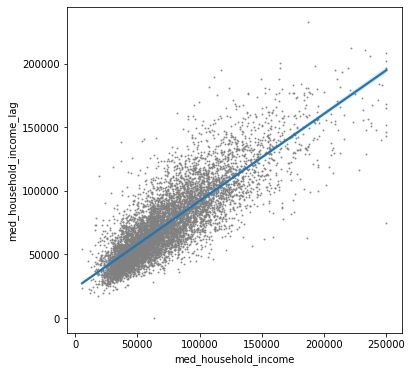

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=col, y=col_lag, data=data_lag, scatter_kws={'s':1, 'color':'gray'})
plt.show()

Notice the 95% confidence interval shading and the positive slope. Given the p-value of Moran's I that we calculated earlier, we can conclude that the slope of the line is statistically-significantly different from zero.

More useful, however, is a standardized Moran plot. Moran's I is the slope of the line in the standardized Moran plot, which makes this all a bit easier to conceptualize.

In [27]:
# standardize the variable's values (i.e., calculate z-scores)
y_std = (y - y.mean()) / y.std()
y_std.head()

GEOID
06001442700    1.209598
06001442800    0.825584
06037204920   -0.904911
06037205110   -0.843647
06037205120   -1.249042
Name: med_household_income, dtype: float64

In [28]:
# compute spatial lag of standardized values and save as series with same index
y_std_lag = pd.Series(libpysal.weights.lag_spatial(w_queen, y_std),
                      index=y_std.index,
                      name=col_lag)
y_std_lag

GEOID
06001442700    0.918063
06001442800    1.214119
06037204920   -0.861681
06037205110   -1.063861
06037205120   -0.848745
                 ...   
06059001303    0.238507
06059001304   -0.123926
06059001401    0.152263
06013367200   -0.481597
06047002402   -0.960948
Name: med_household_income_lag, Length: 7966, dtype: float64

In [29]:
# estimate a simple linear regression model
from scipy.stats import stats
m, b, r, p, se = stats.linregress(x=y_std, y=y_std_lag)
print('m={:.4f}, b={:.4f}, r^2={:.4f}, p={:.4f}'.format(m, b, r ** 2, p))

m=0.6854, b=0.0135, r^2=0.6944, p=0.0000


In [30]:
# the slope is the same as moran's I, calculated earlier
mi.I

0.6855274181193025

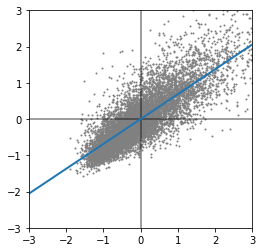

In [31]:
# standardized moran's plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x=y_std, y=y_std_lag, s=1, color='gray')

# draw quadrants and ignore outliers beyond 3 std devs (99.7% of distribution)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# draw a line with moran's I as the slope
Xs = pd.Series([-3, 3])
Ys = Xs * mi.I
line = ax.plot(Xs, Ys, lw=2)

In [ ]:
# now it's your turn
# visualize a standardized moran's plot of median home values


## Local Indicators of Spatial Autocorrelation (LISA)

Local Indicators of Spatial Autocorrelation: are there specific areas with high concentrations of (dis)similar values?

Moran's I tells us about spatial clustering globally across the data set as a whole. However, it does not tell us where these clusters occur. For that, we need a local measure. Essentially, we will classify the data set's observations into four groups based on the four quadrants of the Moran plot:

* HH: high value near other high values (hot spots)
* LL: low value near other low values (cold spots)
* HL: high value near low values (spatial outliers)
* LH: low value near high values (spatial outliers)
Let's see what that looks like, visually.


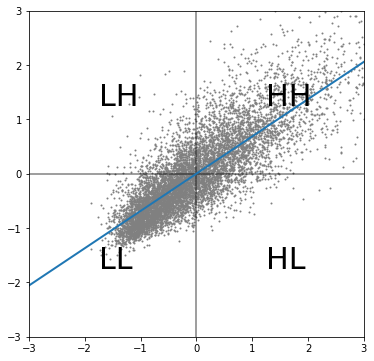

In [32]:
# standardized moran's plot again, from above, but labeled this time
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=y_std, y=y_std_lag, s=1, color='gray')

# draw quadrants and ignore outliers beyond 3 std devs
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# label the quadrants
ax.text(1.25, 1.25, 'HH', fontsize=30)
ax.text(1.25, -1.75, 'HL', fontsize=30)
ax.text(-1.75, 1.25, 'LH', fontsize=30)
ax.text(-1.75, -1.75, 'LL', fontsize=30)

# draw a line with moran's I as the slope
Xs = pd.Series([-3, 3])
Ys = Xs * mi.I
line = ax.plot(Xs, Ys, lw=2)

In [43]:
# calculate LISA values using the queen spatial weights
w_kernel = libpysal.weights.distance.Kernel.from_dataframe(tracts_not_null, fixed=False, k=15)
lisa = esda.Moran_Local(data_lag[col], w_kernel) 

In [44]:
# set the statistical significance threshold (alpha)
alpha = 0.05

In [45]:
# identify whether each observation is significant or not
# p-value interpretation same as earlier with moran's I
data_lag['significant'] = lisa.p_sim < alpha
data_lag['significant'].value_counts()

True     4375
False    3591
Name: significant, dtype: int64

In [46]:
# identify the quadrant each observation belongs to
data_lag['quadrant'] = lisa.q
data_lag['quadrant'] = data_lag['quadrant'].replace({1:'HH', 2:'LH', 3:'LL', 4:'HL'})
data_lag['quadrant'].sort_values().value_counts()

LL    4172
HH    2670
HL     661
LH     463
Name: quadrant, dtype: int64

In [47]:
# what have we got in the end?
data_lag

,med_household_income,med_household_income_lag,significant,quadrant
GEOID,,,,
06001442700,116528,106096,True,HH
06001442800,102788,116689,True,HH
06037204920,40871,42417,True,LL
06037205110,43063,35183,True,LL
06037205120,28558,42880,True,LL
...,...,...,...,...
06059001303,77227,81782,False,HL
06059001304,61736,68814,False,LL
06059001401,61274,78696,False,LH


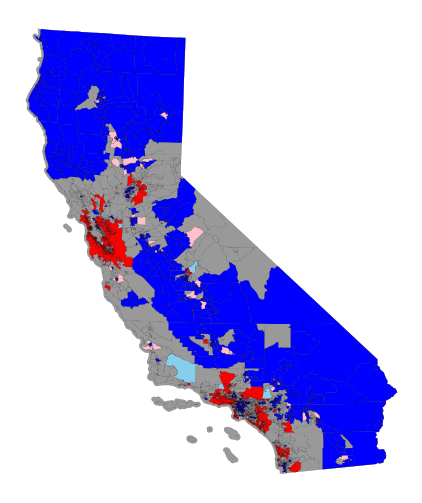

In [48]:
fig, ax = plt.subplots(figsize=(9, 9))

# merge original tracts and LISA quadrants data together, plot tracts basemap
tracts_lisa = tracts.merge(data_lag, how='left', left_index=True, right_index=True)
tracts_lisa.plot(ax=ax, facecolor='#999999', edgecolor='k', linewidth=0.1)

# plot each quandrant's tracts (if significant LISA) in a different color
quadrant_colors = {'HH':'r', 'LL':'b', 'LH':'skyblue', 'HL':'pink'}
for q, c in quadrant_colors.items():
    mask = tracts_lisa['significant'] & (tracts_lisa['quadrant']==q)
    rows = tracts_lisa.loc[mask]
    rows.plot(ax=ax, color=c, edgecolor='k', linewidth=0.1)

ax.axis('off')
fig.savefig('clusters.png', dpi=600, bbox_inches='tight')

* Gray tracts have statistically-insignificant LISA 
value (no local spatial autocorrelation)
* In red we see clusters of tracts with high values surrounded by other high values
* In blue we see clusters of tracts with low values surrounded by other low values
* In pink, we see the first type of spatial outliers: tracts with high values but surrounded by low values
* In light blue we see the other type of spatial outlier: tracts with low values surrounded by other tracts with high values